# Timing Test Simple Client

In [86]:
!pip3 install pyserial
!pip3 install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 7.8 MB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 13.6 MB/s eta 0:00:01
     |████████████████████████████████| 13.3 MB 528 kB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 66 kB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 244 kB 4.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


## Constants and imports
This must match the STM definitions

In [87]:
import serial
import matplotlib.pyplot as plt

START_TEST        = 0b100
BEFORE_SOLENOID   = 0b001
AFTER_SOLENOID    = 0b010
BEAM_READ         = 0b011 
END_TEST          = 0b110   

## Simple data collection
Collects all data until an END_TEST is seen

In [79]:
collected_data = []

def read_data(ser):
    stop = False
    while not stop:
        if ser.in_waiting >= 7:
            data = ser.read(7)
            identifier = (data[0] >> 5) & 0x07

            if identifier == END_TEST:
                stop = True
            
            delimiter = data[6] & 0xFF
                
            if delimiter == 0xFF:
               # print(f"Identifier: {identifier}, Analog Value: {analog_value}, Time: {time_micros}")
                collected_data.append(data)
            else:
                print("Delimiter not found, packet discarded.")

if __name__ == "__main__":
    ser = serial.Serial('/dev/cu.usbserial-110', 9600)  # Adjust the port as needed
    read_data(ser)


In [95]:
identifiers = []
analog_values = []
time_micros = []

for entry in collected_data:
    identifier = (entry[0] >> 5) & 0x07

    if identifier == BEAM_READ:
        analog_value = ((entry[0] & 0x1F) << 5) | ((entry[1] >> 3) & 0x1F)
    else:
        analog_value = None
    time_micro = (entry[2] << 24) | (entry[3] << 16) | (entry[4] << 8) | entry[5]

    identifiers.append(identifier)
    analog_values.append(analog_value)
    time_micros.append(time_micro)


time_micros = [x-time_micros[0] for x in time_micros]

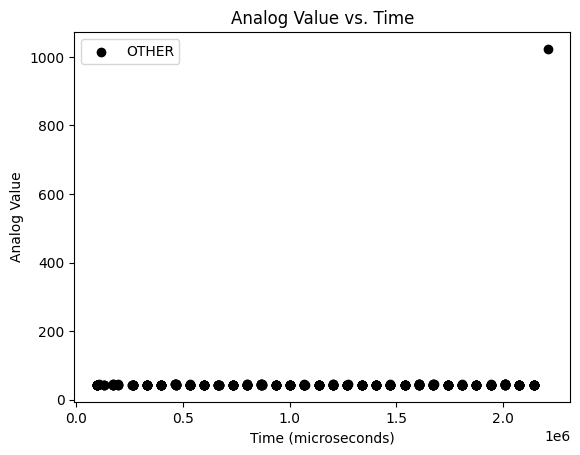

In [92]:

# Plot each point with the specified style and color
for identifier, analog_value, time_micro in zip(identifiers, analog_values, time_micros):
    if identifier == "START_TEST":
        plt.scatter(time_micro, analog_value, color='blue', marker='*', label='START_TEST' if 'START_TEST' not in plt.gca().get_legend_handles_labels()[1] else "")
    elif identifier == "END_TEST":
        plt.scatter(time_micro, analog_value, color='red', marker='*', label='END_TEST' if 'END_TEST' not in plt.gca().get_legend_handles_labels()[1] else "")
    elif identifier == "BEFORE_SOLENOID":
        plt.scatter(time_micro, analog_value, color='yellow', marker='s', label='BEFORE_SOLENOID' if 'BEFORE_SOLENOID' not in plt.gca().get_legend_handles_labels()[1] else "")
    elif identifier == "AFTER_SOLENOID":
        plt.scatter(time_micro, analog_value, color='green', marker='s', label='AFTER_SOLENOID' if 'AFTER_SOLENOID' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:
        plt.scatter(time_micro, analog_value, color='black', marker='o', label='OTHER' if 'OTHER' not in plt.gca().get_legend_handles_labels()[1] else "")

# Adding labels and title
plt.xlabel('Time (microseconds)')
plt.ylabel('Analog Value')
plt.title('Analog Value vs. Time')
plt.legend()
plt.show()
